In [11]:
import numpy as np
import binascii

# the code provides functions to convert text strings to binary representations
# and vice versa using encoding and decoding techniques.


def text_to_binary(text, encoding='utf-8', errors='surrogatepass'):
    binary = bin(int(binascii.hexlify(text.encode(encoding, errors)), 16))[2:]
    return binary.zfill(8 * ((len(binary) + 7) // 8))

def binary_to_text(binary, encoding='utf-8', errors='surrogatepass'):
    decimal = int(binary, 2)
    return decimal_to_text(decimal).decode(encoding, errors)

def decimal_to_text(decimal):
    hex_string = '%x' % decimal
    n = len(hex_string)
    return binascii.unhexlify(hex_string.zfill(n + (n & 1)))


In [12]:
bin(8) #bin() function

'0b1000'

In [4]:
text1='hello'
text1.encode('utf-8','surrogatepass') #b means it has been converted to bytes

b'hello'

In [5]:
binascii.hexlify(text1.encode('utf-8','surrogatepass'))

b'68656c6c6f'

In [6]:
int(binascii.hexlify(text1.encode('utf-8','surrogatepass')),16)

448378203247

In [7]:
bin(448378203247)

'0b110100001100101011011000110110001101111'

In [19]:
print(binary_to_text('0110100001100101011011000110110001101111'))

hello


In [20]:
print(decimal_to_text(556937573))

b'!21e'


In [18]:
print(text_to_binary('hello'))

0110100001100101011011000110110001101111


In [13]:
# Main building blocks of Grain Cipher, namely a Linear Feedback Shift Register (LFSR)
# and a Non-linear Feedback Shift Register (NFSR)

lfsr = np.zeros(80,dtype=bool)
nfsr = np.zeros(80,dtype=bool)

#This line creates a NumPy array called lfsr with a length of 80 elements,
# all initialized to False (boolean value False). The dtype=bool argument
# specifies that the array should have a boolean data type



In [21]:
## Initialise LFSR and NFSR using IV and Secret Key
## First load the NFSR with the key bits, bi = ki, 0 ≤ i ≤ 79,
## then load the first 64 bits of the LFSR with the IV, si = IVi, 0 ≤ i ≤ 63.
## The remaining bits of the LFSR are filled with ones, si = 1, 64 ≤ i ≤ 79.
## Because of this the LFSR cannot be initialized to the all zero state.

def init(iv,key):
    iv_bin = text_to_binary(iv)
    iv_bin = ''.join(iv_bin)
    lfsr[:64] = [bool(int(iv_bin[ix])) for ix in range(len(iv_bin))]
    lfsr[64:] = 1
    key_bin = text_to_binary(key)
    key_bin = ''.join(key_bin)
    nfsr[:] = [bool(int(key_bin[ix])) for ix in range(len(key_bin))]

In [24]:
init('absolute','california')
print(lfsr)
print(nfsr)

[False  True  True False False False False  True False  True  True False
 False False  True False False  True  True  True False False  True  True
 False  True  True False  True  True  True  True False  True  True False
  True  True False False False  True  True  True False  True False  True
 False  True  True  True False  True False False False  True  True False
 False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False  True  True False False False  True  True False  True  True False
 False False False  True False  True  True False  True  True False False
 False  True  True False  True False False  True False  True  True False
 False  True  True False False  True  True False  True  True  True  True
 False  True  True  True False False  True False False  True  True False
  True  True  True False False  True  True False  True False False  True
 False  True  True False False False False  True]


In [27]:
## The cipher is clocked 160 times without producing any running key
## The output of the filter function, h(x), is fed back and xored with the input, both to the LFSR and to the NFSR

def clock():
    hx=0
    fx=0
    gx=0
    global lfsr
    global nfsr
    for ix in range(160):
        fx = lfsr[62] ^ lfsr[51] ^ lfsr[38] ^ lfsr[23] ^ lfsr[13] ^ lfsr[0] ^ hx
       # This line computes the value for fx by performing XOR operations (^)
       # on specific bits of the lfsr array (bit positions 62, 51, 38, 23, 13, and 0)
       # and the current value of hx. fx here represents the update function of lfsr

        gx = hx ^ nfsr[0] ^ nfsr[63] ^ nfsr[60] ^ nfsr[52] ^ nfsr[45] ^ nfsr[37] ^ nfsr[33] ^ nfsr[28] ^ nfsr[21] ^ nfsr[15] ^ nfsr[19] ^ nfsr[0] ^ nfsr[63] & nfsr[60] ^ nfsr[37] & nfsr[33] ^ nfsr[15] & nfsr[9] ^ nfsr[60] & nfsr[52] & nfsr[45] ^ nfsr[33] & nfsr[28] & nfsr[21] ^ nfsr[63] & nfsr[45] & nfsr[28] & nfsr[9] ^ nfsr[60] & nfsr[52] & nfsr[37] & nfsr[33] ^ nfsr[63] & nfsr[60] & nfsr[21] & nfsr[15] ^ nfsr[63] & nfsr[60] & nfsr[52] & nfsr[45] & nfsr[37] ^ nfsr[33] & nfsr[28] & nfsr[21] & nfsr[15] & nfsr[9] ^ nfsr[52] & nfsr[45] & nfsr[37] & nfsr[33] & nfsr[28] & nfsr[21]
        x0 = lfsr[0]
        x1 = lfsr[25]
        x2 = lfsr[46]
        x3 = lfsr[64]
        x4 = nfsr[63]
        hx = x1 ^ x4 ^ x0 & x3 ^ x2 & x3 ^ x3 & x3 ^ x0 & x1 & x2 ^ x0 & x2 & x3 ^ x0 & x2 & x4 ^ x1 & x2 & x4 ^ x2 & x3 & x4
        lfsr[:-1] = lfsr[1:]
        lfsr[-1] = fx
        nfsr[:-1] = nfsr[1:]
        nfsr[-1] = gx

        #the clock() function implements the clocking mechanism for a cryptographic
        #cipher that utilizes LFSRs and NFSRs. It performs a series of XOR and logical
        #operations on specific elements of the lfsr and nfsr arrays, updates the fx and gx variables,
        #computes hx, and shifts the elements of the arrays to prepare for the next clock cycle.

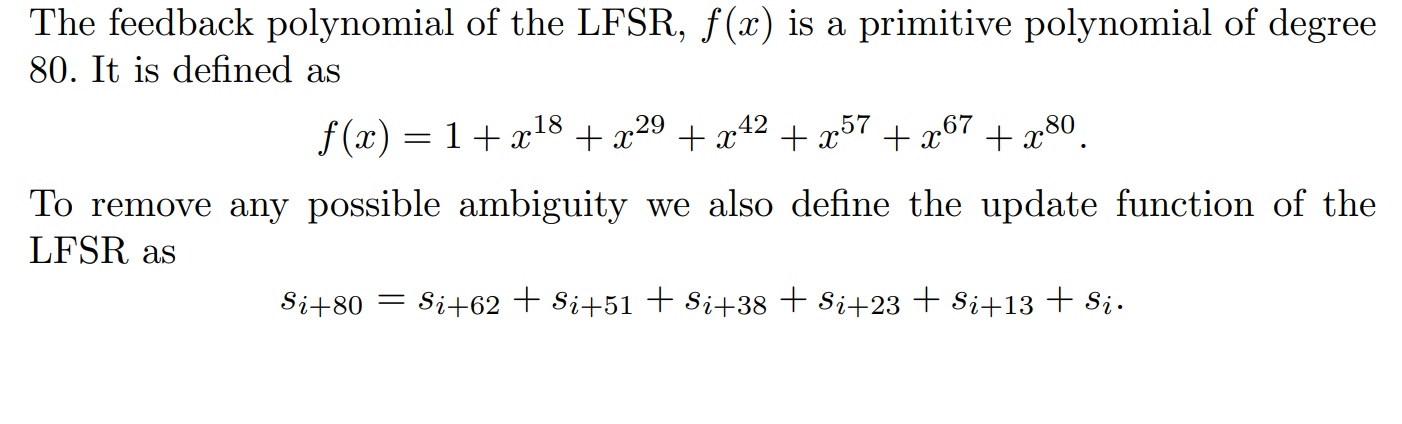

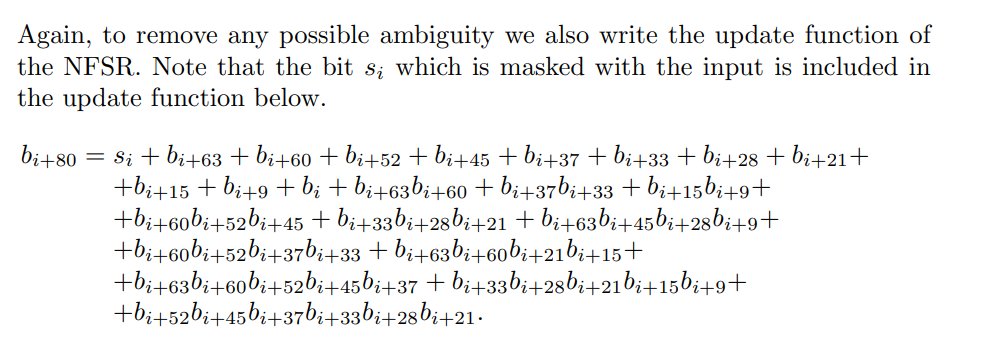

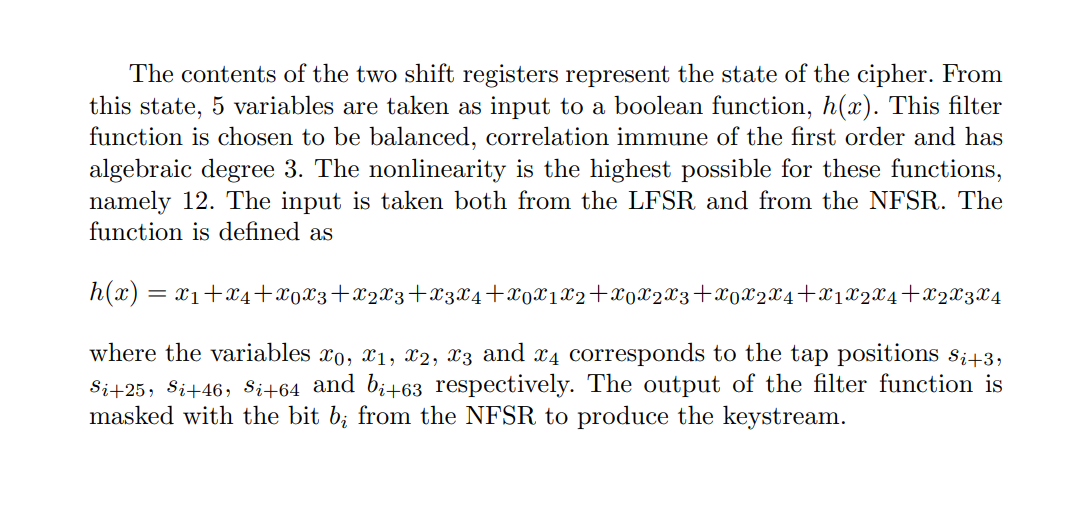

In [28]:
clock()

In [30]:
## Return a stream generator which implements the filter function

def gen_key_stream():
    hx = 0
    while True:
        fx = lfsr[62] ^ lfsr[51] ^ lfsr[38] ^ lfsr[23] ^ lfsr[13] ^ lfsr[0]
        gx = nfsr[0] ^ nfsr[63] ^ nfsr[60] ^ nfsr[52] ^ nfsr[45] ^ nfsr[37] ^ nfsr[33] ^ nfsr[28] ^ nfsr[21] ^ nfsr[15] ^ nfsr[19] ^ nfsr[0] ^ nfsr[63] & nfsr[60] ^ nfsr[37] & nfsr[33] ^ nfsr[15] & nfsr[9] ^ nfsr[60] & nfsr[52] & nfsr[45] ^ nfsr[33] & nfsr[28] & nfsr[21] ^ nfsr[63] & nfsr[45] & nfsr[28] & nfsr[9] ^ nfsr[60] & nfsr[52] & nfsr[37] & nfsr[33] ^ nfsr[63] & nfsr[60] & nfsr[21] & nfsr[15] ^ nfsr[63] & nfsr[60] & nfsr[52] & nfsr[45] & nfsr[37] ^ nfsr[33] & nfsr[28] & nfsr[21] & nfsr[15] & nfsr[9] ^ nfsr[52] & nfsr[45] & nfsr[37] & nfsr[33] & nfsr[28] & nfsr[21]
        x0 = lfsr[0]
        x1 = lfsr[25]
        x2 = lfsr[46]
        x3 = lfsr[64]
        x4 = nfsr[63]
        hx = x1 ^ x4 ^ x0 & x3 ^ x2 & x3 ^ x3 & x3 ^ x0 & x1 & x2 ^ x0 & x2 & x3 ^ x0 & x2 & x4 ^ x1 & x2 & x4 ^ x2 & x3 & x4
        lfsr[:-1] = lfsr[1:]
        lfsr[-1] = fx
        nfsr[:-1] = nfsr[1:]
        nfsr[-1] = gx
        yield hx

In [31]:
def encrypt(iv,key,plain):
    init(iv,key)
    clock()
    plain = text_to_binary(plain)
    stream = gen_key_stream()
    cipher = [str(int(bool(int(plain[ix]))^next(stream))) for ix in range(len(plain))]
    cipher = ''.join(cipher)
    return cipher

In [33]:
cipher = encrypt('absolute','california','First Test')
print(cipher)

10100111011001110111001000010001001010110000100001100101001000111010101101000111


In [34]:
def decrypt(iv,key,cipher):
    init(iv,key)
    clock()
    stream = gen_key_stream()
    plain = [str(int(bool(int(cipher[ix]))^next(stream))) for ix in range(len(cipher))]
    plain = ''.join(plain)
    plain = binary_to_text(plain)
    return plain

In [ ]:
plain = decrypt('absolute','california',cipher)
print (plain)